# Digital Signal Processing - Riyal or Pake


## Preparation

In [157]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from IPython.display import Audio


In [158]:
FakePath = r"Audio\Training\fake"
RealPath = r"Audio\Training\real"

We then create a metadata to map the file path to the label

In [159]:
try:
    df = pd.read_csv("metadata.csv")
except:
    rows = []

    # for FAKE files
    for file in os.listdir(FakePath):
        if file.lower().endswith((".wav", ".mp3", ".flac")):
            rows.append([os.path.join(FakePath, file), "fake"])

    # for REAL files
    for file in os.listdir(RealPath):
        if file.lower().endswith((".wav", ".mp3", ".flac")):
            rows.append([os.path.join(RealPath, file), "real"])


    df = pd.DataFrame(rows, columns=["filepath", "label"])
    df.to_csv("metadata.csv", index=False)

df

,filepath,label
0,Audio\Training\fake\file1.mp3.wav_16k.wav_norm...,fake
1,Audio\Training\fake\file100.mp3.wav_16k.wav_no...,fake
2,Audio\Training\fake\file10003.mp3.wav_16k.wav_...,fake
3,Audio\Training\fake\file10012.wav_16k.wav_norm...,fake
4,Audio\Training\fake\file10017.wav_16k.wav_norm...,fake
...,...,...
10793,Audio\Training\real\file9974.wav_16k.wav_norm....,real
10794,Audio\Training\real\file9976.wav_16k.wav_norm....,real
10795,Audio\Training\real\file998.wav_16k.wav_norm.w...,real
10796,Audio\Training\real\file9983.wav_16k.wav_norm....,real


We then check the balance of the label to ensure our model didnt get bias

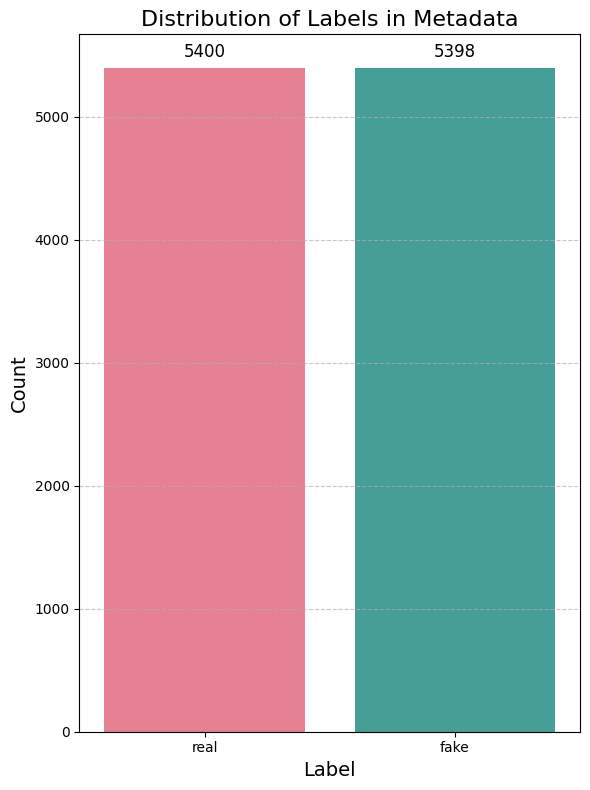

In [160]:
label_counts = df['label'].value_counts()

plt.figure(figsize=(6, 8))

sns.barplot(hue=label_counts.index, x=label_counts.index, y=label_counts.values, palette='husl', legend=False)

plt.title('Distribution of Labels in Metadata', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)

for i, count in enumerate(label_counts.values):
    plt.text(i, count + max(label_counts.values)*0.01, str(count),
             ha='center', va='bottom', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Feature Extraction

We use mfcc-20 to do feature extraction. We use sample rate of 16000 which are the standard and also extract features such as:
* Centroid & Bandwidth: To measure how bright and rich the voices is.
* ZCR & Roll-Off: To measure static noises and high-frequency cut-offs
* Variance: To measure the change in values for the voices

In [161]:
def extract_features(path):
    """
    function to extract features from audio file
    """
    y, sr = librosa.load(path, sr=44100)

    mfcc_feat = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40), axis=1)
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr), axis=1)
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr), axis=1)
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr), axis=1)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y), axis=1)

    return np.hstack([mfcc_feat, centroid, bandwidth, rolloff, zcr])



In [ ]:
try:
    X = np.load("X.npy")
    y = np.load("y.npy")
except:
    X = []
    y = []

    meta = df
    total = len(meta)
    with tqdm(total=total, desc="Extracting features") as pbar:
        for fp, label in zip(meta.filepath, meta.label):
            X.append(extract_features(fp))
            y.append(0 if label == "fake" else 1)
            pbar.update(1)

    X = np.array(X)
    y = np.array(y)

In [166]:
mfcc_cols = [f"mfcc_{i+1}" for i in range(40)]
other_cols = ["centroid", "bandwidth", "rolloff", "zcr"]

columns = mfcc_cols + other_cols
columns.append("label")

df_features = pd.DataFrame(np.hstack([X, y.reshape(-1,1)]), columns=columns)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(df_features)

           mfcc_1      mfcc_2     mfcc_3     mfcc_4     mfcc_5     mfcc_6  \
0     -275.791382  210.621979  -9.541645  36.118946  23.818981   6.136023   
1     -317.764099  155.115265  -6.209198   5.638924  33.697735   1.518047   
2     -312.995209  190.685654 -48.088692  53.344772  39.138260   2.629755   
3     -328.377930  152.351089  -3.212160  43.769726  64.497696   0.242827   
4     -294.611115  154.027161 -21.036230  12.689486  28.660589 -12.596212   
...           ...         ...        ...        ...        ...        ...   
10248 -305.950043  131.079300 -16.789635  37.865368  16.657789 -18.162533   
10249 -350.915253  134.544724 -18.901388  39.375061  31.500923 -15.178882   
10250 -225.498352  185.585632 -32.887405  37.982319  25.804508  -5.764766   
10251 -433.270050   68.025810  14.342797  43.172253  21.033812   8.758389   
10252 -292.636810  176.431625 -18.530035  22.918222   9.022613 -14.891981   

          mfcc_7     mfcc_8     mfcc_9    mfcc_10    mfcc_11    mfcc_12  \


In [167]:
desc = df_features[mfcc_cols].describe()

variance = df_features[mfcc_cols].var()
desc.loc['var'] = variance

print(desc)

             mfcc_1        mfcc_2        mfcc_3        mfcc_4        mfcc_5  \
count  10253.000000  10253.000000  10253.000000  10253.000000  10253.000000   
mean    -293.599908    165.646065    -22.970524     26.348945     22.503017   
std       35.653387     26.831572     21.537435     16.177349     13.424550   
min     -481.398651     11.017515   -132.979523    -44.262867    -32.092892   
25%     -317.852386    146.692490    -36.397976     16.728523     12.403954   
50%     -293.451477    167.052567    -22.612791     27.628534     22.938919   
75%     -267.798401    184.935593    -10.325232     37.756138     31.801291   
max      -97.909264    275.319031     54.396259     73.693481     89.083450   
var     1271.164037    719.933266    463.861100    261.706619    180.218554   

             mfcc_6        mfcc_7        mfcc_8        mfcc_9       mfcc_10  \
count  10253.000000  10253.000000  10253.000000  10253.000000  10253.000000   
mean     -11.617324      4.010228     -8.811285    

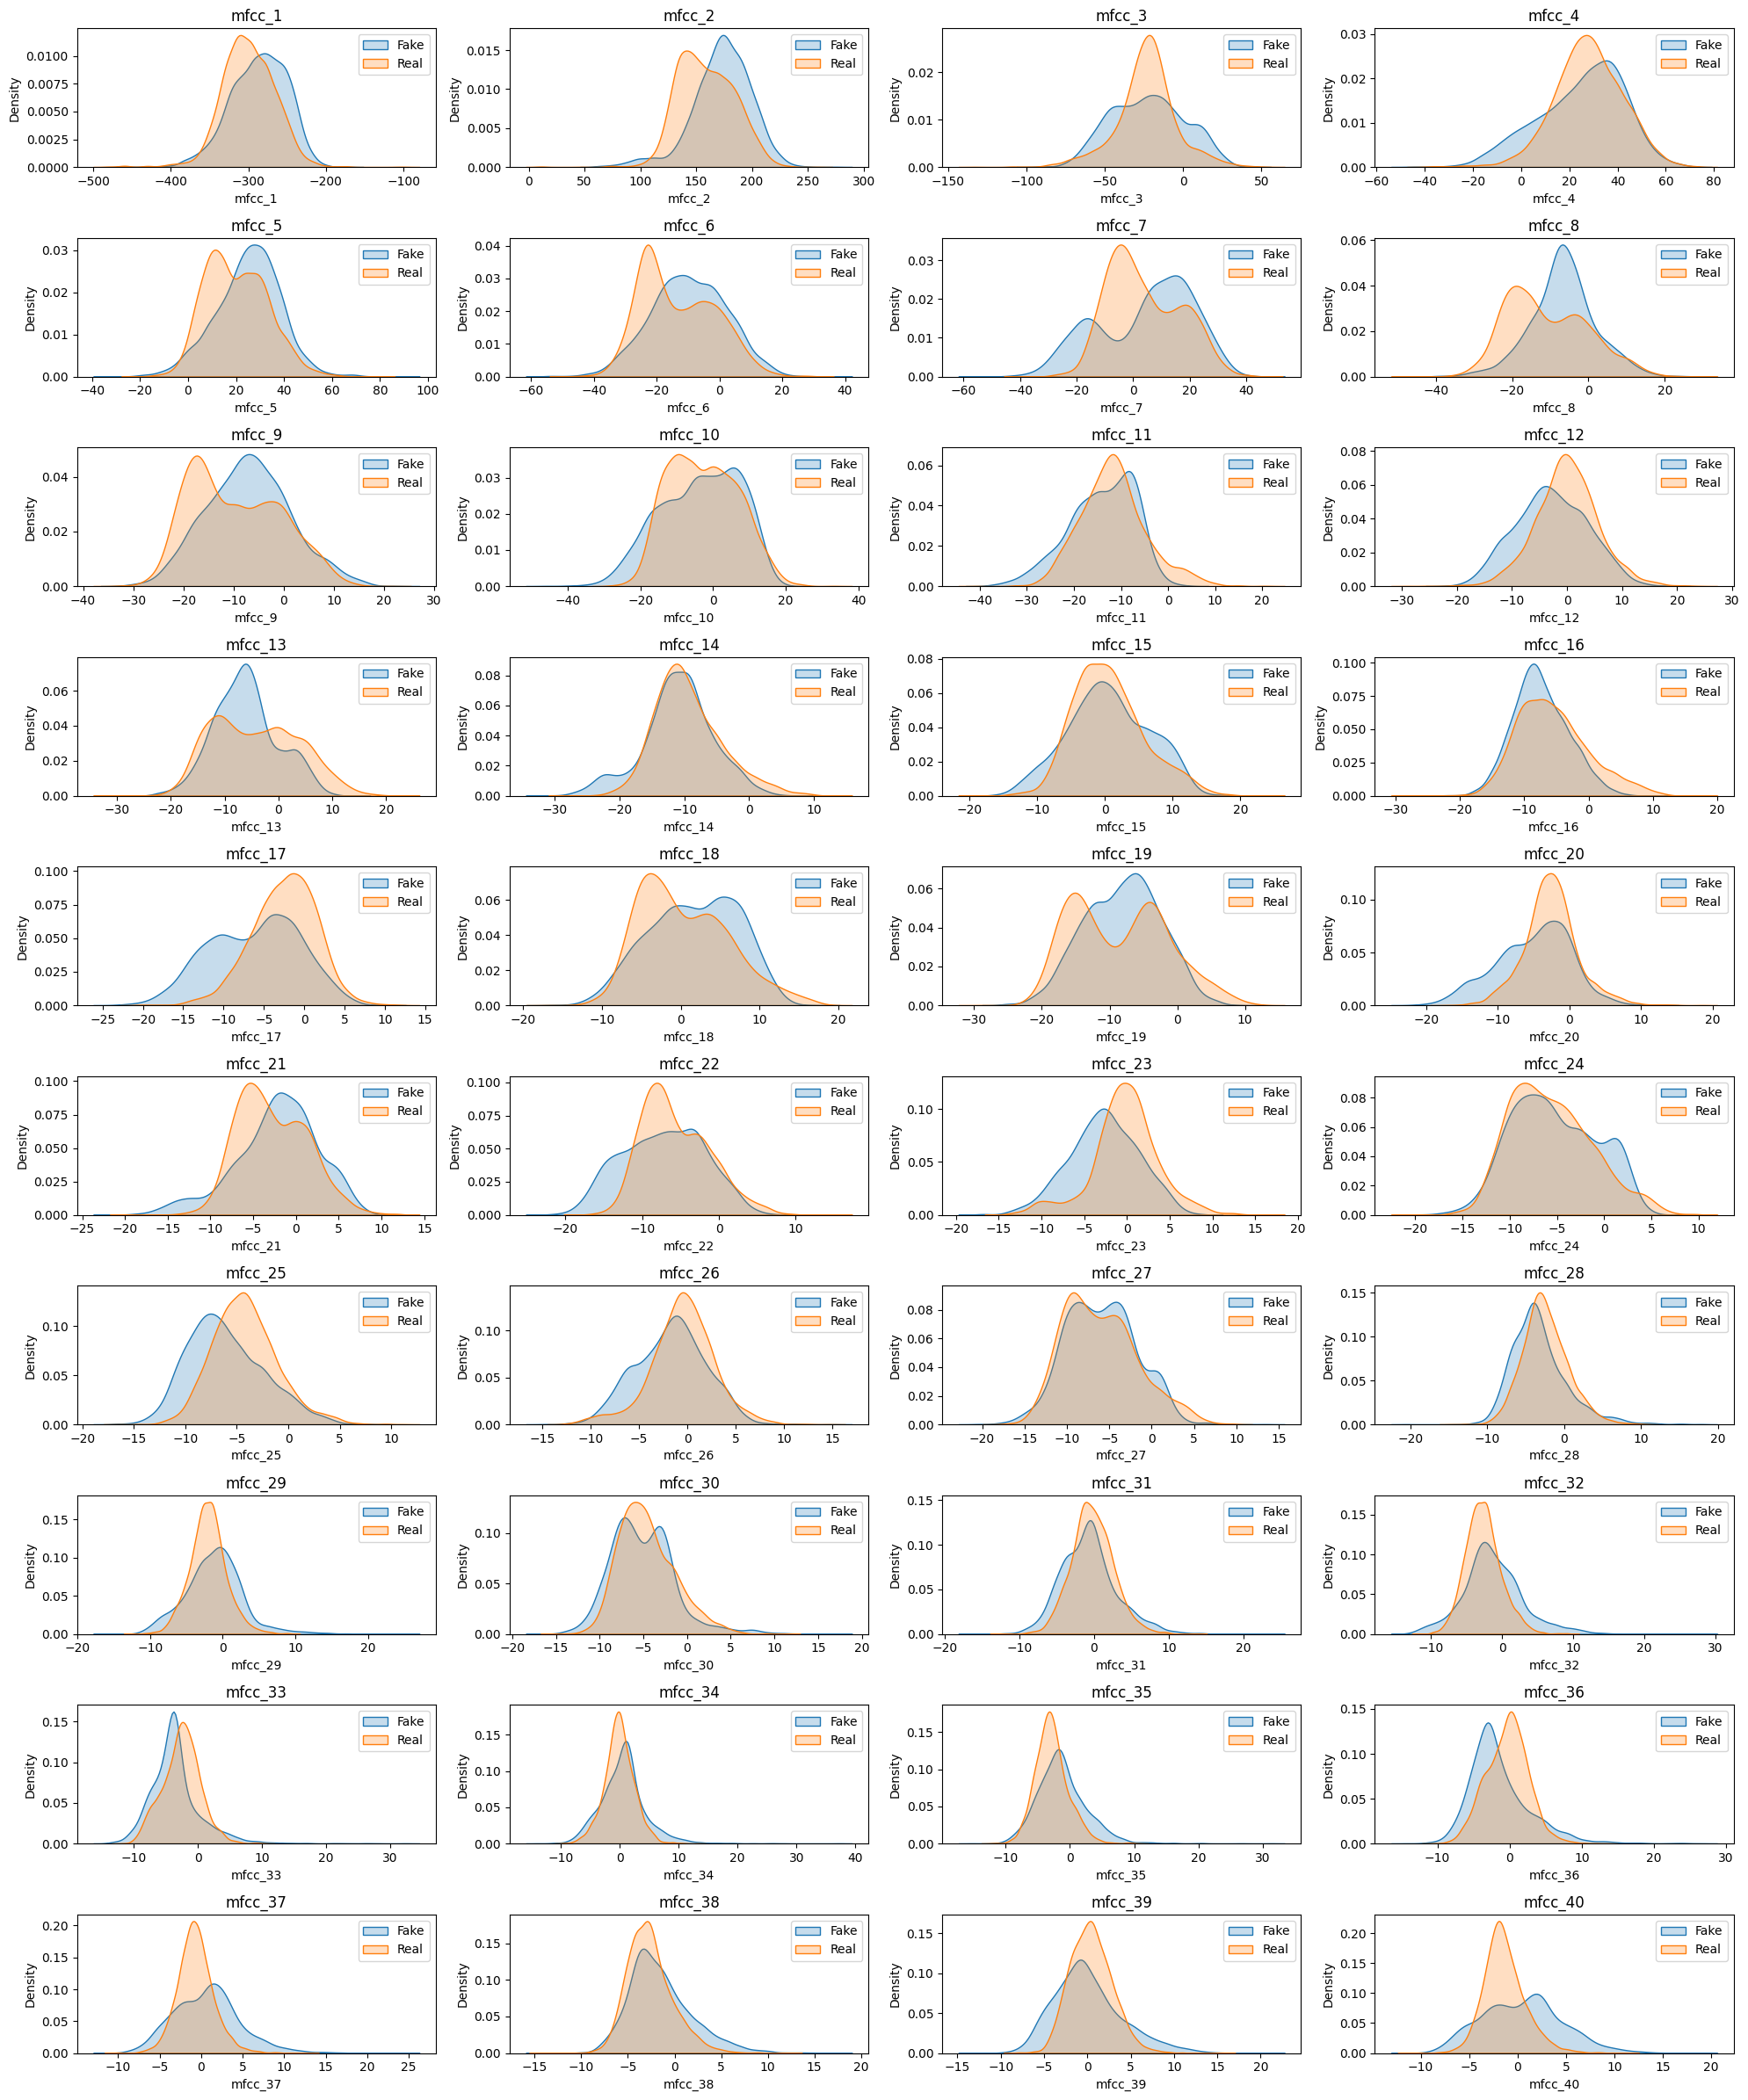

In [168]:
df_fake = df_features[df_features['label'] == 0]
df_real = df_features[df_features['label'] == 1]

fig, axes = plt.subplots(10, 4, figsize=(20, 24))
axes = axes.flatten()

for ax, feature in zip(axes, mfcc_cols):
    sns.kdeplot(df_fake[feature], label='Fake', fill=True, ax=ax)
    sns.kdeplot(df_real[feature], label='Real', fill=True, ax=ax)
    ax.set_title(f'{feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend()


plt.tight_layout()
plt.show()


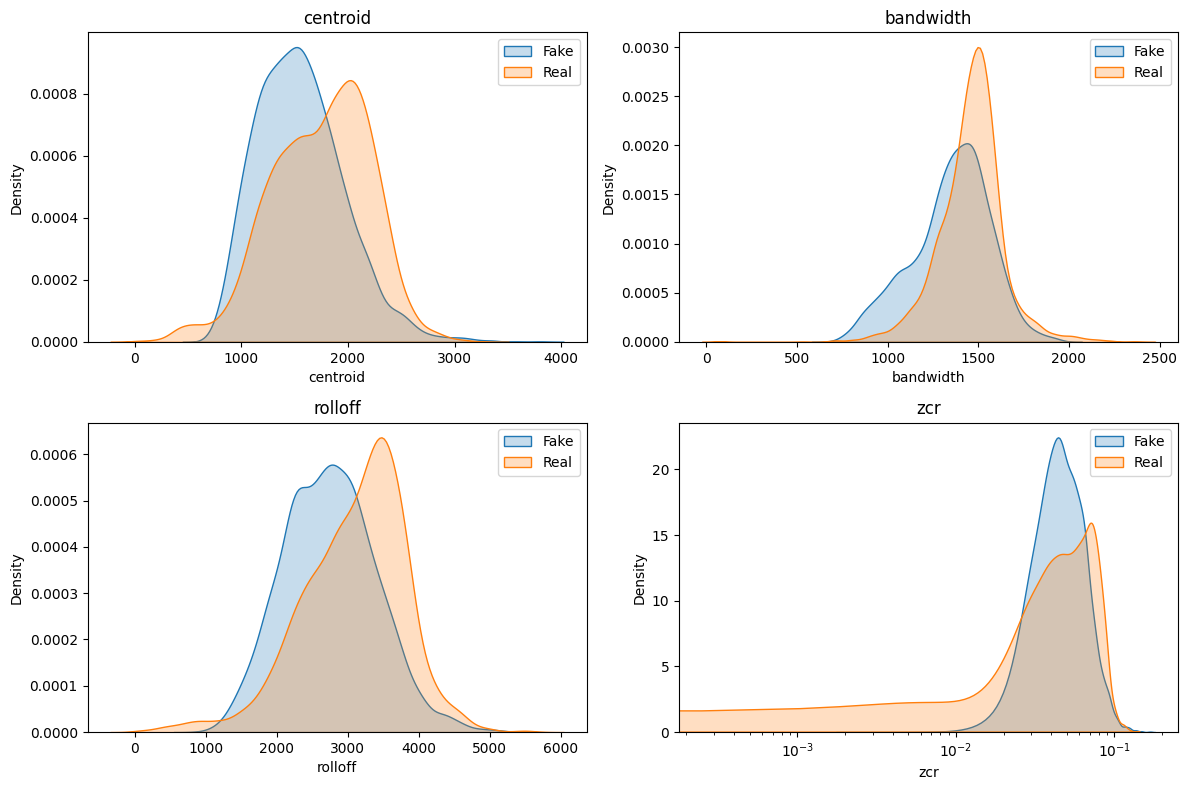

In [169]:
key_features = ['centroid', 'bandwidth', 'rolloff', 'zcr']


fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, feature in zip(axes, key_features):
    sns.kdeplot(df_fake[feature], label='Fake', fill=True, ax=ax)
    sns.kdeplot(df_real[feature], label='Real', fill=True, ax=ax)
    ax.set_title(f'{feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend()
    
plt.xscale("log")
plt.tight_layout()
plt.show()

## Dimension Reduction

If we look at the correlation heatmap below, we will see that some features are having too much correlation. Meaning that we need to do reduction dimension

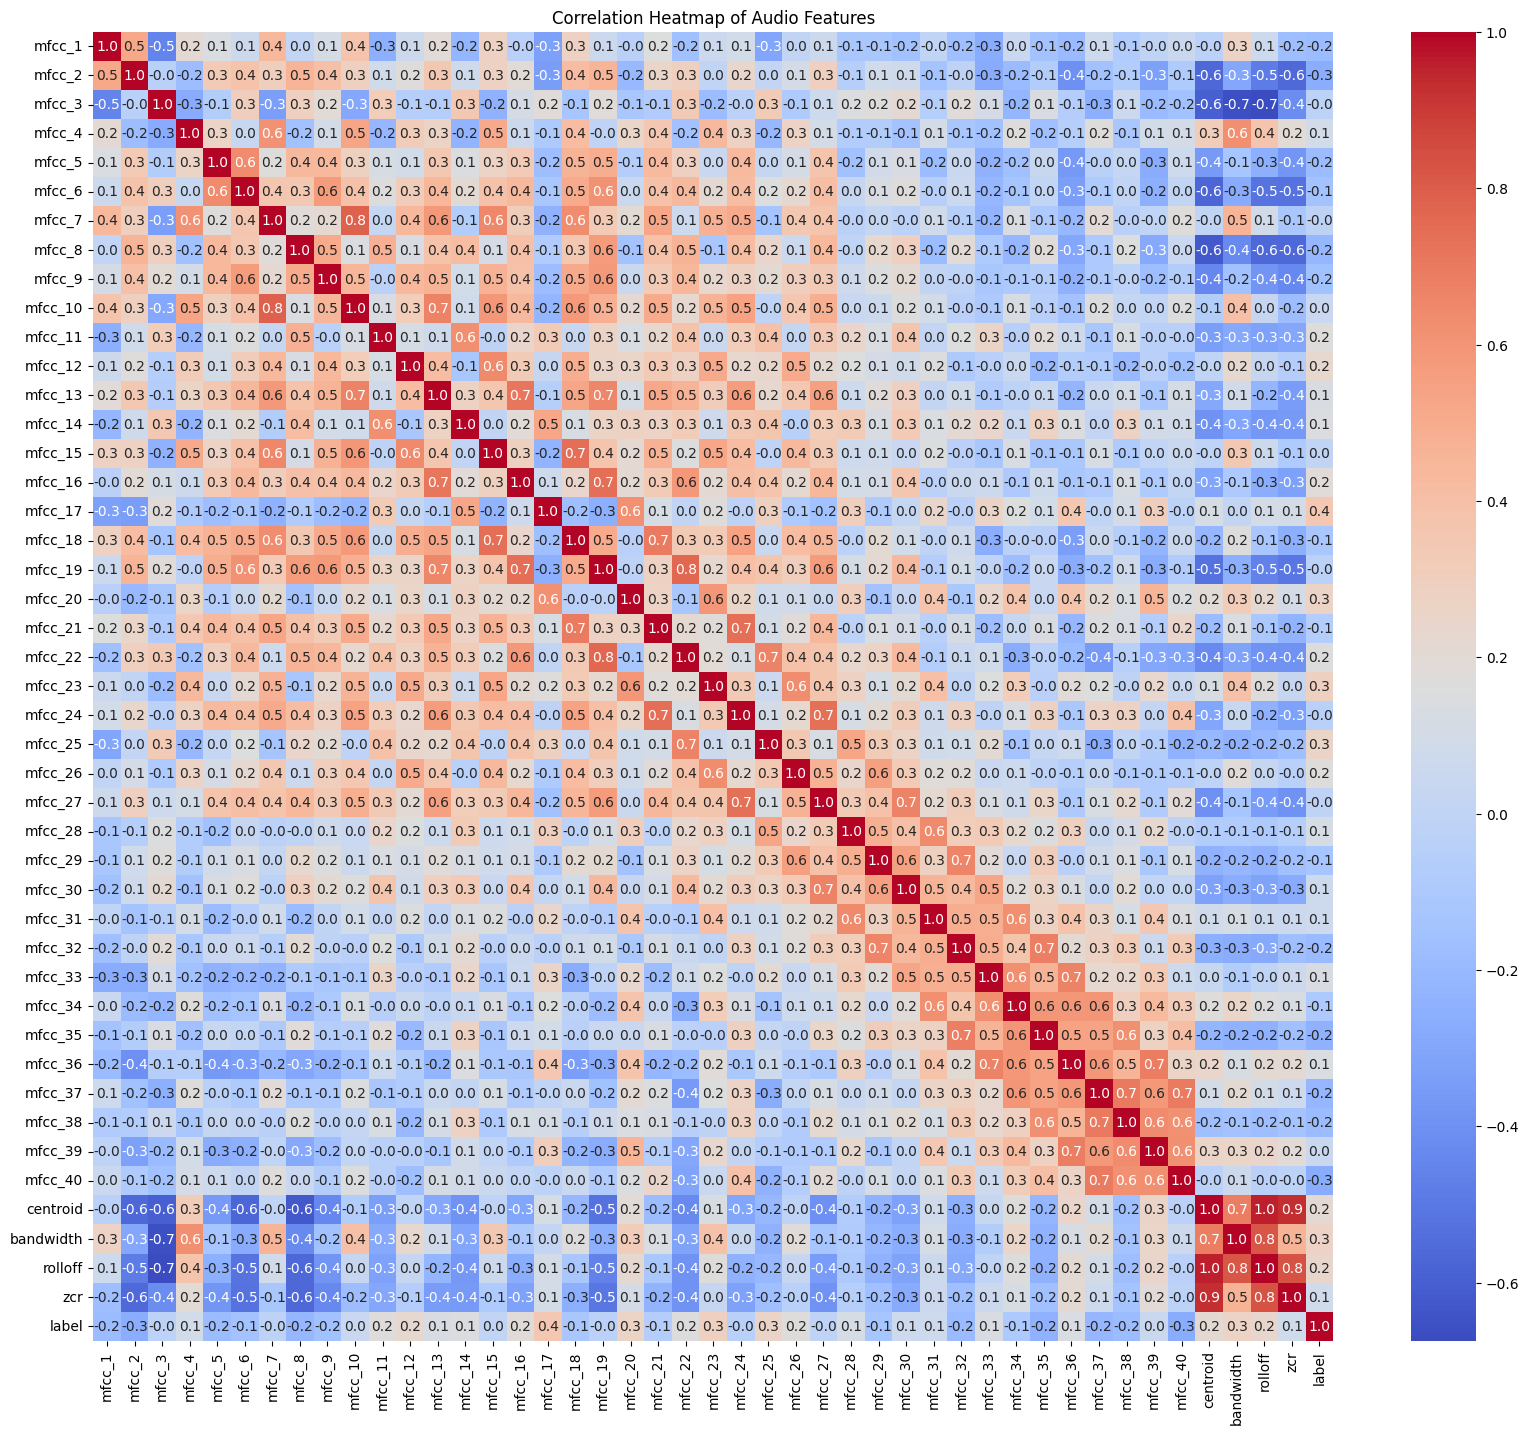

In [190]:
plt.figure(figsize=(20, 17))
sns.heatmap(df_features.corr(numeric_only=True), annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Correlation Heatmap of Audio Features')
plt.show()

Firstly before do dimension reduction, we need to check the skewness

In [171]:
print(df_features.skew().sort_values())

mfcc_17     -0.467927
mfcc_4      -0.461901
bandwidth   -0.444610
mfcc_20     -0.337925
mfcc_2      -0.269171
mfcc_1      -0.256942
mfcc_23     -0.211664
rolloff     -0.194742
mfcc_26     -0.184601
mfcc_21     -0.178542
mfcc_7      -0.164758
mfcc_10     -0.130789
mfcc_12     -0.061598
label       -0.052889
mfcc_3      -0.033003
mfcc_11     -0.032393
mfcc_22      0.089872
mfcc_5       0.094640
mfcc_8       0.117468
centroid     0.126472
mfcc_19      0.137536
mfcc_6       0.152735
mfcc_14      0.163155
mfcc_18      0.165640
mfcc_9       0.203734
mfcc_15      0.208891
zcr          0.285242
mfcc_24      0.293437
mfcc_25      0.304431
mfcc_13      0.322208
mfcc_27      0.336867
mfcc_31      0.482737
mfcc_16      0.569864
mfcc_29      0.640081
mfcc_39      0.698605
mfcc_30      0.755514
mfcc_40      0.763995
mfcc_28      0.771706
mfcc_37      0.861199
mfcc_36      0.881656
mfcc_32      0.899531
mfcc_34      0.919013
mfcc_33      1.011203
mfcc_38      1.032615
mfcc_35      1.055611
dtype: flo

We will also check the outliers

In [173]:
Q1 = df_features[['centroid', 'zcr']].quantile(0.25)
Q3 = df_features[['centroid', 'zcr']].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mask = (df_features[['centroid', 'zcr']] < (lower_bound)) | (df_features[['centroid', 'zcr']] > (upper_bound))
outliers = mask.sum()

outlier_rows = df_features[mask.any(axis=1)]
print(outliers)
print('\n')
print("Outlier if:")
print(f"centroid < {lower_bound['centroid']} or > {upper_bound['centroid']}")
print("OR")
print(f"zcr < {lower_bound['zcr']} or > {upper_bound['zcr']}")
print('\n')
print(f"Found {len(outlier_rows)} outlier")

centroid    42
zcr         60
dtype: int64


Outlier if:
centroid < 321.70473984945045 or > 2971.163574315723
OR
zcr < -0.0062993829900568135 or > 0.11525157581676136


Found 70 outlier


However not all outlier is bad, the paper actually keeps most outlier and only delete the silence

In [174]:
silencer_mask = (df_features['zcr'] < 0.0001) | (df_features['centroid'] < 100)
silencer_rows = df_features[silencer_mask]
print(f"Found {len(silencer_rows)} silence")

Found 10 silence


In [175]:
keep = ~silencer_mask
df_features = df_features[keep]
X_ = X[keep]
y_ = y[keep]

X = X_
y = y_

But, before we do PCA, we need to split and scale the data first

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Now we can do the PCA

In [177]:
n_features = X_train_scaled.shape[1]

if n_features > 65:
    pca = PCA(n_components=65)
else:
    pca = PCA(n_components=0.95)

X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

In [191]:
print(f"Original number of features: {n_features}")
print(f"Reduced number of features after PCA: {X_train.shape[1]}")

Original number of features: 44
Reduced number of features after PCA: 22


# Modelling (Gradient Boost Classifier)

We decided to use GBClassifier because based on the paper we read that the method are the best for this spesific dataset.
Though there is method such as XGBoost which is the direct upgrade of the models, the vanilla GBClassfier still got the upperhand.

In [185]:
try:
    gb_model = joblib.load("models/gb_model.pkl")
except:
    gb_model = GradientBoostingClassifier(
        n_estimators=1000,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )

    gb_model.fit(X_train, y_train)


FINAL ACCURACY: 97.95%
              precision    recall  f1-score   support

        Fake       0.98      0.98      0.98      1028
        Real       0.98      0.98      0.98      1021

    accuracy                           0.98      2049
   macro avg       0.98      0.98      0.98      2049
weighted avg       0.98      0.98      0.98      2049



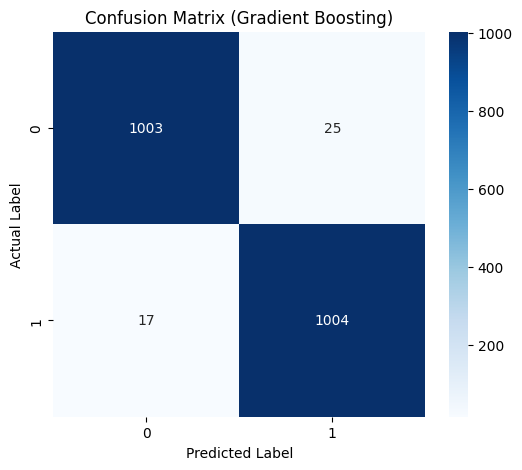

In [179]:
y_pred = gb_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\nFINAL ACCURACY: {acc*100:.2f}%")
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Gradient Boosting)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [180]:
def predict_audio(audio_path, model, scaler, pca):
    """
    funct to predict an unlabeled audio
    """
    f = extract_features(audio_path)
    f = f.reshape(1, -1)
    f = scaler.transform(f)
    f = pca.transform(f)
    prediction = model.predict(f)
    label = "FAKE" if prediction[0] == 0 else "REAL"
    return label

In [196]:
audio_files = [
    r"Audio\Testing\Fake bgt.wav",
    r"Audio\Testing\Real bgt.wav"
]

for filename in audio_files:
    if os.path.exists(filename):
        try:
            display(Audio(filename))
            prediction = predict_audio(filename, gb_model, scaler, pca)

            color = "\033[92m" if prediction == "REAL" else "\033[91m"
            reset = "\033[0m"
            print(f"{filename} → {color}{prediction}{reset}")

        except Exception as e:
            print(f"Error processing {filename}: {e}")
    else:
        print(f"File not found: {filename}")


Audio\Testing\Fake bgt.wav → FAKE


Audio\Testing\Real bgt.wav → REAL


## Spectogram

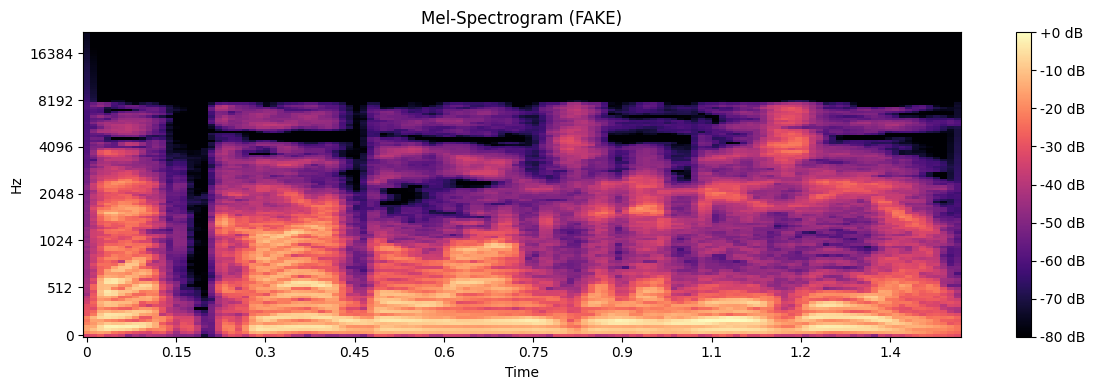

In [182]:
df_f = df[df['label'] == 'fake'].reset_index(drop=True)
label = df_f['label'].iloc[0]
path = df_f['filepath'].iloc[0]


y, sr = librosa.load(path, sr=44100)

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=22050)

S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(S_dB, sr=sr,
                         x_axis='time',
                         y_axis='mel',
                         fmax=22050,
                         cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel-Spectrogram ({label.upper()})')
plt.tight_layout()
plt.show()

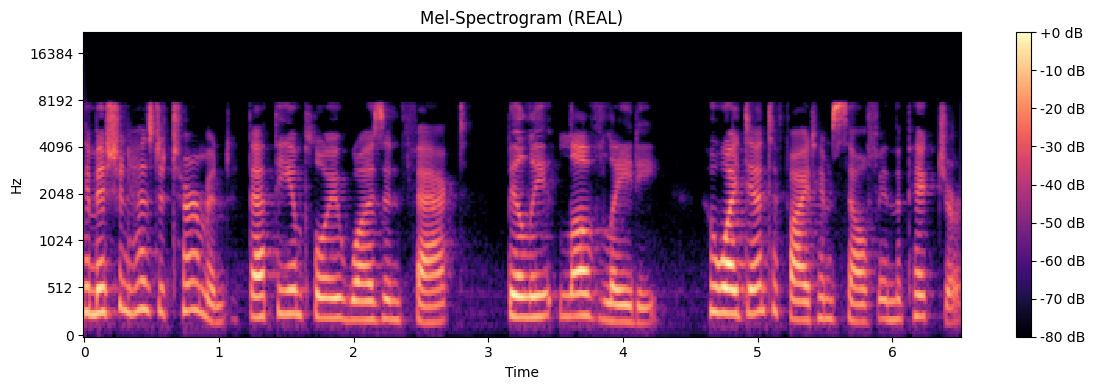

In [183]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

df_r = df[df['label'] == 'real']
label = df_r['label'].iloc[0]
path = df_r['filepath'].iloc[0]

y, sr = librosa.load(path, sr=44100)

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=22050)

S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(S_dB, sr=sr,
                         x_axis='time',
                         y_axis='mel',
                         fmax=22050,
                         cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel-Spectrogram ({label.upper()})')
plt.tight_layout()
plt.show()

In [184]:
os.makedirs("models", exist_ok=True)

joblib.dump(gb_model, "models/gb_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")
joblib.dump(pca, "models/pca.pkl")


['models/pca.pkl']